In [1]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3629, done.
remote: Total 3629 (delta 0), reused 0 (delta 0), pack-reused 3629
Receiving objects: 100% (3629/3629), 632.96 MiB | 35.27 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
Checking out files: 100% (1173/1173), done.


In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [17]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import cv2 
from imutils import paths
import os 

In [18]:
data_dir='/content/covid-chestxray-dataset'

In [19]:
image_paths=list(paths.list_images(data_dir))

In [20]:
data=[]
Label=[]
print("[INFO] loading images...")
for image_path in image_paths:
  label=image_path.split(os.path.sep)[-2]
  image=cv2.imread(image_path)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image=cv2.resize(image,(256,256))
  data.append(image)
  Label.append(label)

[INFO] loading images...


In [21]:
Images=np.array(data,dtype=np.float32)/255.0
labels=np.array(Label)

In [22]:
from sklearn.model_selection import train_test_split

In [29]:
x_train,x_test,_,_=train_test_split(Images,labels)

In [36]:
x_train=x_train.reshape(-1,256,256,1)
x_test=x_test.reshape(-1,256,256,1)

In [37]:
#@markdown ### 3.5. Define loss and model
# LOSS
def dice_coeff(y_true, y_pred):
    smooth =0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


#MODEL
def create_model(input_shape=(256,256, 1), init_nb=16, num_classes=1):
    
    inputs = Input(input_shape)
    
    down1 = Conv2D(init_nb, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1pool = Conv2D(init_nb, (3, 3), padding='same', strides=(2, 2))(down1)
    down1pool = BatchNormalization()(down1pool)
    down1pool = Activation('relu')(down1pool)
    
    down2 = Conv2D(init_nb * 2, (3, 3), padding='same')(down1pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2pool = Conv2D(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(down2)
    down2pool = BatchNormalization()(down2pool)
    down2pool = Activation('relu')(down2pool)

    down3 = Conv2D(init_nb * 4, (3, 3), padding='same')(down2pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3pool = Conv2D(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(down3)
    down3pool = BatchNormalization()(down3pool)
    down3pool = Activation('relu')(down3pool)
    
    # stacked dilated convolution
    dilate1 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=1)(down3pool)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=2)(dilate1)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=4)(dilate2)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=8)(dilate3)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)
    
    dilate_all_added = add([dilate1, dilate2, dilate3, dilate4])
    
    up3 = Conv2DTranspose(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(dilate_all_added)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = add([down3, up3])
    up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    
    up2 = Conv2DTranspose(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(up3)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = add([down2, up2])
    up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    
    up1 = Conv2DTranspose(init_nb, (3, 3), padding='same', strides=(2, 2))(up2)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = add([down1, up1])
    up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    return model

In [40]:
disturbution=tf.distribute.experimental.CentralStorageStrategy()
lr=0.0001  
loss=bce_dice_loss
with disturbution.scope():

  model=create_model()
  model.compile(optimizer=RMSprop(lr), loss=loss, metrics=[dice_coeff])
  model.summary()


INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 256, 256, 16) 64          conv2d_56[0][0]                  
_____________________________________________________

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-3)]

In [42]:
model.fit(x_train,x_train,epochs=30,verbose=1,callbacks=callbacks)

Epoch 1/30
27/27 [==============================] - 11s 238ms/step - loss: 1.1789 - dice_coeff: 0.5008
Epoch 2/30
27/27 [==============================] - 6s 241ms/step - loss: 0.8682 - dice_coeff: 0.6335
Epoch 3/30
27/27 [==============================] - 7s 242ms/step - loss: 0.7985 - dice_coeff: 0.6730
Epoch 4/30
27/27 [==============================] - 7s 244ms/step - loss: 0.7958 - dice_coeff: 0.6840
Epoch 5/30
27/27 [==============================] - 7s 242ms/step - loss: 0.7734 - dice_coeff: 0.6953
Epoch 6/30
27/27 [==============================] - 7s 241ms/step - loss: 0.7608 - dice_coeff: 0.7026
Epoch 7/30
27/27 [==============================] - 7s 241ms/step - loss: 0.7645 - dice_coeff: 0.7044
Epoch 8/30
27/27 [==============================] - 6s 240ms/step - loss: 0.7563 - dice_coeff: 0.7076
Epoch 9/30
27/27 [==============================] - 6s 241ms/step - loss: 0.7587 - dice_coeff: 0.7073
Epoch 10/30
27/27 [==============================] - 7s 241ms/step - loss: 0.7601

KeyboardInterrupt: ignored

In [ ]:
predict=model.predict(train_x)

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 

In [ ]:
for i in range(100):
  plt.figure()
  plt.imshow(np.squeeze(predict[i,:,:,:]),cmap='gray')



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predict2=model.predict(train)

In [ ]:
for i in range(len(predict2)):
  plt.figure()
  plt.imshow(predict[i,:,:,0])

In [ ]:
imgs=predict[1,:,:]

In [ ]:
imgs.shape

(256, 256, 1)

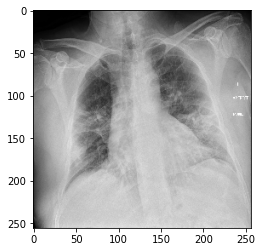

In [ ]:
plt.imshow(train_x[80],cmap='gray')

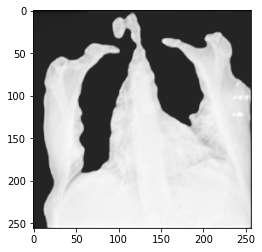

In [ ]:
plt.imshow(np.squeeze(predict[80,:,:,:]),cmap='gray')